# Model Analysis
This notebook trains a machine learning model to predict LaLiga match outcomes. The model classifies each match as:
- **1**: Home team wins
- **3**: Away team wins
- **2**: Draw

## Step 1: Data Preprocessing

In [1]:
# import libraries ncessary for preprocessing
import pandas as pd
import numpy as np
import sqlite3

from sklearn.model_selection import train_test_split

In [2]:
# create a connection with the given database
con = sqlite3.connect("../laliga.sqlite")

# read the matches table from the database into Pandas DataFrames
df_matches = pd.read_sql_query("SELECT * from Matches", con)

# close the connection of the database
con.close()

In [3]:
def count_points(last_5):
    if last_5 == 0:
        return 0
        
    count = 0
    for i in last_5:
        if i == 'W':
            count += 3
        elif i == 'T':
            count += 1
    return count

def extend_data(input_data):
    data = input_data.copy()
    
    # drop the "time" column because it contains to many "None" values, and the "date" column because it is not used
    data.drop(columns = ['time', 'date'], inplace = True)
    
    # drop NaN values (there are only NaN values left in the "score" column)
    data.dropna(inplace = True)
    
    # create two new columns, one for the score of the home team, and one for the score of the away team, drop the score column
    data[['home_score', 'away_score']] = data['score'].str.split(':', expand=True).astype(int)
    data.drop(columns=['score'], inplace = True)
    
    # create a new column to show which team won (1 for home team, 2 for away team and 'X' for a draw)
    data['winner'] = data.apply(lambda row: 1 if row['home_score'] > row['away_score'] else 2 if row['home_score'] < row['away_score'] else 'X', axis=1)

    data_copy = data.dropna(subset=['home_score', 'away_score', 'winner'])

    # Calculate cumulative results for home and away games
    home_stats = data_copy.groupby(['season', 'division', 'matchday', 'home_team']).agg(
        GF=('home_score', 'sum'), GA=('away_score', 'sum'),
        W=('winner', lambda x: (x == 1).sum()),
        L=('winner', lambda x: (x == 2).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'home_team': 'team', 'result': 'home_result'})
    
    away_stats = data_copy.groupby(['season', 'division', 'matchday', 'away_team']).agg(
        GF=('away_score', 'sum'), GA=('home_score', 'sum'),
        W=('winner', lambda x: (x == 2).sum()),
        L=('winner', lambda x: (x == 1).sum()),
        T=('winner', lambda x: (x == 'X').sum())
    ).reset_index().rename(columns={'away_team': 'team', 'result': 'away_result'})

    # Combine home and away stats
    combined_stats = pd.concat([home_stats, away_stats]).fillna(0)
    combined_stats['GD'] = combined_stats['GF'] - combined_stats['GA']
    combined_stats['Pts'] = combined_stats['W'] * 3 + combined_stats['T']
    combined_stats['result'] = combined_stats.apply(lambda row: 'W' if row['W'] > 0 else ('L' if row['L'] > 0 else 'T'), axis=1)

    # Calculate cumulative season stats and rankings
    results = combined_stats.groupby(['season', 'division', 'matchday', 'team']).agg(
        GF=('GF', 'sum'), GA=('GA', 'sum'), GD=('GD', 'sum'),
        W=('W', 'sum'), L=('L', 'sum'), T=('T', 'sum'),
        Pts=('Pts', 'sum'), result=('result', 'first')
    ).reset_index()

    results = results.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'])
    results[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']] = results.groupby(['season', 'division', 'team'])[['GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts']].cumsum()

    results = results.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[True, True, True, False, False, False])    
    results['rank'] = results.groupby(['season', 'division', 'matchday']).cumcount() + 1
    results = results.sort_values(by=['season', 'division', 'matchday', 'rank'], ascending=[False, True, True, True]).reset_index(drop=True)

    results = results[['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'result']]

    # Calculate last 5 games results and prepare home/away final resultsframes
    results['last_5'] = results.apply(lambda row: results[
        (results['season'] == row['season']) &
        (results['division'] == row['division']) &
        (results['matchday'] <= row['matchday']) &
        (results['matchday'] >= max(1, row['matchday'] - 4)) &
        (results['team'] == row['team'])
    ]['result'].tolist()[-5:], axis=1)

    results['last_5'] = results['last_5'].apply(lambda x: count_points(x))    
    
    results_shifted = results.copy()
    results_shifted['matchday'] += 1
    
    # Rename columns in results_shifted for clarity when merged
    results_shifted = results_shifted.rename(columns={
        'rank': 'prev_rank',
        'GF': 'prev_GF', 'GA': 'prev_GA', 'GD': 'prev_GD',
        'W': 'prev_W', 'L': 'prev_L', 'T': 'prev_T', 'Pts': 'prev_Pts',
        'result': 'prev_result', 'last_5': 'prev_last_5'
    })
    
    # Merge data with the shifted results to get previous matchday stats
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'home_team'], 
                      right_on=['season', 'division', 'matchday', 'team']).fillna(0)
    
    # Drop the redundant 'team' column from the merged results_shifted dataframe
    data.drop(columns=['team'], inplace=True)
    
    # Repeat the merge for the away team data
    data = data.merge(results_shifted, 
                      how='left', 
                      left_on=['season', 'division', 'matchday', 'away_team'], 
                      right_on=['season', 'division', 'matchday', 'team'], 
                      suffixes=('_home', '_away')).fillna(0)
    
    # Drop the redundant 'team' column from the second merge
    data.drop(columns=['team'], inplace=True)

    data['GDD'] = data['prev_GD_home'] - data['prev_GD_away']

    data['winner'] = data.apply(lambda row: 1 if row['winner'] == 1 else 2 if row['winner'] == 2 else 0, axis=1)
    
    return data

In [4]:
# select the right seasons for the training and testing data
training_data = df_matches[df_matches['season'].isin(['2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])]
testing_data = df_matches[df_matches['season'] == '2020-2021']

In [5]:
# extend the training data
training_data = extend_data(training_data)
training_data

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,prev_GF_away,prev_GA_away,prev_GD_away,prev_W_away,prev_L_away,prev_T_away,prev_Pts_away,prev_result_away,prev_last_5_away,GDD
0,2010-2011,1,1,Hércules CF,Athletic,0,1,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,2010-2011,1,1,Málaga CF,Valencia,1,3,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,2010-2011,1,1,Levante,Sevilla FC,1,4,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,2010-2011,1,1,Espanyol,Getafe,3,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,2010-2011,1,1,Real Sociedad,Villarreal,1,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8415,2019-2020,2,42,CD Numancia,CD Tenerife,2,1,1,20.0,43.0,...,49.0,44.0,5.0,14.0,14.0,13.0,55.0,L,6.0,-14.0
8416,2019-2020,2,42,Racing,Rayo Vallecano,1,2,2,22.0,38.0,...,58.0,49.0,9.0,12.0,8.0,21.0,57.0,T,8.0,-25.0
8417,2019-2020,2,42,Sporting Gijón,SD Huesca,0,1,2,11.0,40.0,...,54.0,42.0,12.0,20.0,14.0,7.0,67.0,W,9.0,-9.0
8418,2019-2020,2,42,Real Zaragoza,Ponferradina,2,1,1,5.0,57.0,...,44.0,48.0,-4.0,12.0,14.0,15.0,51.0,W,3.0,9.0


In [6]:
# extend the testing data
testing_data = extend_data(testing_data)
testing_data

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,prev_GF_away,prev_GA_away,prev_GD_away,prev_W_away,prev_L_away,prev_T_away,prev_Pts_away,prev_result_away,prev_last_5_away,GDD
0,2020-2021,1,1,SD Eibar,Celta de Vigo,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,2020-2021,1,1,Granada CF,Athletic,2,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,2020-2021,1,1,Cádiz CF,CA Osasuna,0,2,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,2020-2021,1,1,Alavés,Real Betis,0,1,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,2020-2021,1,1,Real Valladolid,Real Sociedad,1,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,2020-2021,2,42,CD Mirandés,CE Sabadell,0,2,2,9.0,38.0,...,38.0,48.0,-10.0,10.0,18.0,13.0,43.0,W,6.0,9.0
838,2020-2021,2,42,Ponferradina,RCD Mallorca,2,2,0,8.0,43.0,...,52.0,26.0,26.0,24.0,8.0,9.0,81.0,W,13.0,-31.0
839,2020-2021,2,42,Rayo Vallecano,CD Lugo,0,1,2,6.0,52.0,...,37.0,53.0,-16.0,10.0,17.0,14.0,44.0,W,8.0,29.0
840,2020-2021,2,42,Real Zaragoza,CD Leganés,0,5,2,14.0,37.0,...,46.0,32.0,14.0,20.0,11.0,10.0,70.0,W,9.0,-15.0


In [7]:
training_data['winner'].value_counts()

winner
1    3927
0    2268
2    2225
Name: count, dtype: int64

In [8]:
from sklearn.utils import resample

# Separate each class into different DataFrames
class_1 = training_data[training_data['winner'] == 1]
class_0 = training_data[training_data['winner'] == 0]
class_2 = training_data[training_data['winner'] == 2]

# Find the size of the majority class
majority_size = class_1.shape[0]

# Oversample the minority classes to match the majority class size
class_0_oversampled = resample(class_0, replace=True, n_samples=majority_size, random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=majority_size, random_state=42)

# Concatenate the oversampled minority classes with the majority class
balanced_training_data = pd.concat([class_1, class_0_oversampled, class_2_oversampled])

# Shuffle the balanced data
balanced_training_data = balanced_training_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
balanced_training_data['winner'].value_counts()


winner
2    3927
0    3927
1    3927
Name: count, dtype: int64

In [9]:
balanced_training_data

,season,division,matchday,home_team,away_team,home_score,away_score,winner,prev_rank_home,prev_GF_home,...,prev_GF_away,prev_GA_away,prev_GD_away,prev_W_away,prev_L_away,prev_T_away,prev_Pts_away,prev_result_away,prev_last_5_away,GDD
0,2012-2013,1,14,Sevilla FC,Real Valladolid,1,2,2,10.0,18.0,...,18.0,14.0,4.0,5.0,5.0,3.0,18.0,W,8.0,-4.0
1,2017-2018,1,37,Real Betis,Sevilla FC,2,2,0,5.0,56.0,...,46.0,56.0,-10.0,16.0,14.0,6.0,54.0,W,8.0,10.0
2,2019-2020,2,34,Albacete,SD Huesca,2,2,0,17.0,25.0,...,43.0,35.0,8.0,16.0,12.0,5.0,53.0,L,7.0,-21.0
3,2012-2013,1,7,Real Zaragoza,Getafe,0,1,2,15.0,5.0,...,7.0,10.0,-3.0,2.0,3.0,1.0,7.0,W,7.0,0.0
4,2014-2015,2,35,CA Osasuna,Albacete,2,1,1,20.0,30.0,...,41.0,50.0,-9.0,11.0,15.0,8.0,41.0,W,10.0,-11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11776,2012-2013,1,14,Dep. La Coruña,Real Betis,2,3,2,17.0,19.0,...,20.0,22.0,-2.0,7.0,5.0,1.0,22.0,W,9.0,-7.0
11777,2019-2020,2,15,UD Las Palmas,Alcorcón,1,1,0,13.0,15.0,...,19.0,17.0,2.0,5.0,4.0,5.0,20.0,W,8.0,-5.0
11778,2011-2012,2,20,Real Valladolid,Alcorcón,1,1,0,4.0,29.0,...,20.0,20.0,0.0,7.0,7.0,5.0,26.0,T,8.0,12.0
11779,2014-2015,1,24,Atlético Madrid,UD Almería,3,0,1,3.0,47.0,...,22.0,36.0,-14.0,6.0,12.0,5.0,23.0,T,7.0,39.0


In [10]:
# define features (X) and target (y)
target = 'winner'
features = ['prev_rank_home', 'prev_rank_away', 'prev_last_5_home', 'prev_last_5_away', 'GDD', 'prev_T_home', 'prev_T_away']

# split the data
X_train = balanced_training_data[features]
X_test = testing_data[features]
y_train = balanced_training_data[target]
y_test = testing_data[target]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (11781, 7)
X_test shape: (842, 7)
y_train shape: (11781,)
y_test shape: (842,)


## Step 3: Model Training and Hyperparameter Tuning

In [11]:
# import libraries ncessary for models
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

## Step 4: Model Evaluation and Interpretation

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Naive Bayes Gaussian Accuracy: 0.4346793349168646
Naive Bayes Gaussian Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.46      0.39       241
           1       0.53      0.45      0.49       358
           2       0.43      0.40      0.41       243

    accuracy                           0.43       842
   macro avg       0.44      0.43      0.43       842
weighted avg       0.45      0.43      0.44       842



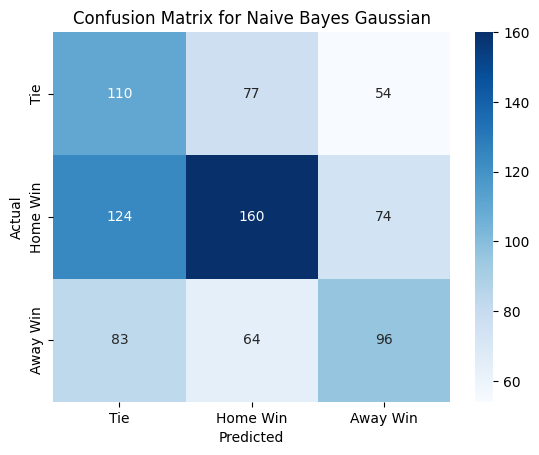

In [13]:
# Predictions using the best models
y_pred_gnb = gnb.fit(X_train, y_train).predict(X_test)

# Evaluation for Naive Bayes Gaussian
print("Naive Bayes Gaussian Accuracy:", accuracy_score(y_test, y_pred_gnb))
print("Naive Bayes Gaussian Classification Report:\n", classification_report(y_test, y_pred_gnb))

# Confusion matrix for Naive Bayes Gaussian
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tie', 'Home Win', 'Away Win'], yticklabels=['Tie', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes Gaussian')
plt.show()

In [ ]:

# Optimized function for feature engineering
def optimized_extend_data(input_data):
    data = input_data.copy()
    
    # Dropping unnecessary columns and handling missing values
    data.drop(columns=['time', 'date'], inplace=True)
    data.dropna(inplace=True)
    
    # Split the score column and determine the winner
    data[['home_score', 'away_score']] = data['score'].str.split(':', expand=True).astype(int)
    data['winner'] = np.where(data['home_score'] > data['away_score'], 1,
                              np.where(data['home_score'] < data['away_score'], 2, 0))
    data.drop(columns=['score'], inplace=True)
    
    # Aggregating home and away stats without looping
    home_stats = data.groupby(['season', 'division', 'matchday', 'home_team']).agg(
        GF_home=('home_score', 'sum'), GA_home=('away_score', 'sum'),
        W_home=('winner', lambda x: (x == 1).sum()), L_home=('winner', lambda x: (x == 2).sum()),
        T_home=('winner', lambda x: (x == 0).sum())
    ).reset_index().rename(columns={'home_team': 'team'})

    away_stats = data.groupby(['season', 'division', 'matchday', 'away_team']).agg(
        GF_away=('away_score', 'sum'), GA_away=('home_score', 'sum'),
        W_away=('winner', lambda x: (x == 2).sum()), L_away=('winner', lambda x: (x == 1).sum()),
        T_away=('winner', lambda x: (x == 0).sum())
    ).reset_index().rename(columns={'away_team': 'team'})

    # Merge home and away stats
    combined_stats = pd.merge(home_stats, away_stats, on=['season', 'division', 'matchday', 'team'], how='outer').fillna(0)
    combined_stats['GF'] = combined_stats['GF_home'] + combined_stats['GF_away']
    combined_stats['GA'] = combined_stats['GA_home'] + combined_stats['GA_away']
    combined_stats['GD'] = combined_stats['GF'] - combined_stats['GA']
    combined_stats['Pts'] = (combined_stats['W_home'] + combined_stats['W_away']) * 3 + (combined_stats['T_home'] + combined_stats['T_away'])

    # Cumulative season stats
    cumulative_stats = combined_stats.groupby(['season', 'division', 'team']).apply(
        lambda x: x.sort_values(by='matchday').assign(
            cum_GF=x['GF'].cumsum(),
            cum_GA=x['GA'].cumsum(),
            cum_GD=x['GD'].cumsum(),
            cum_Pts=x['Pts'].cumsum()
        )
    ).reset_index(drop=True)

    # Shift cumulative stats for next matchday and rename
    cumulative_stats_shifted = cumulative_stats.copy()
    cumulative_stats_shifted['matchday'] += 1
    cumulative_stats_shifted = cumulative_stats_shifted.rename(columns={
        'cum_GF': 'prev_GF', 'cum_GA': 'prev_GA', 'cum_GD': 'prev_GD', 'cum_Pts': 'prev_Pts'
    })
    
    # Merging cumulative stats for home and away teams
    data = data.merge(cumulative_stats_shifted.add_suffix('_home'), left_on=['season', 'division', 'matchday', 'home_team'],
                      right_on=['season_home', 'division_home', 'matchday_home', 'team_home'], how='left').fillna(0)
    data = data.merge(cumulative_stats_shifted.add_suffix('_away'), left_on=['season', 'division', 'matchday', 'away_team'],
                      right_on=['season_away', 'division_away', 'matchday_away', 'team_away'], how='left').fillna(0)

    # Create differential feature
    data['GDD'] = data['prev_GD_home'] - data['prev_GD_away']

    # Finalize target variable encoding
    data['winner'] = data['winner'].astype(int)
    
    return data

# Apply optimized function to the training data
training_data = optimized_extend_data(df_matches)


In [ ]:

# Select numeric columns and target
X_train_full_numeric = training_data.drop(columns=['winner', 'home_team', 'away_team', 'division', 'season']).select_dtypes(include=[np.number])
y_train_full = training_data['winner']

# Faster feature selection using SelectFromModel with RandomForest
from sklearn.feature_selection import SelectFromModel
sfm_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")
sfm_selector.fit(X_train_full_numeric, y_train_full)

# Selected features
selected_features_sfm = X_train_full_numeric.columns[sfm_selector.get_support()]
X_train_selected_sfm = X_train_full_numeric[selected_features_sfm]

# Model testing with Random Forest and Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Dictionary to store models and their cross-validation scores
model_performance = {}

# Define models to test
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GaussianNB": GaussianNB()
}

# Evaluate each model
for model_name, model in models.items():
    cv_scores_model = cross_val_score(model, X_train_selected_sfm, y_train_full, cv=5, scoring='accuracy')
    model_performance[model_name] = {
        "Average Accuracy": np.mean(cv_scores_model),
        "CV Scores": cv_scores_model
    }

# Display performance summary
model_performance


In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cross-validation accuracy plot
model_names = list(model_performance.keys())
average_accuracies = [model_performance[model]["Average Accuracy"] for model in model_names]

plt.figure(figsize=(10, 6))
plt.barh(model_names, average_accuracies, color='skyblue')
plt.xlabel("Average Cross-Validation Accuracy")
plt.title("Model Comparison - Cross-Validation Accuracy")
plt.show()

# Best model confusion matrix (Random Forest)
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train_selected_sfm, y_train_full)
y_pred = best_model.predict(X_train_selected_sfm)

# Confusion Matrix plot
cm = confusion_matrix(y_train_full, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest (Training Set)")
plt.show()
